In [3]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from custom_crypt.crypt import *

import time
import socket
import datetime
import numpy as np
import pandas as pd
import json
from dateutil.parser import parse
import warnings
warnings.filterwarnings("ignore")

from analysis_evo.data.mongo_storage import MongoStorage
from rebalance.single_simulation import PortfolioSimulation
from rebalance.full_simulation import FullPortfolioSimulation, StatisticalTest
from simulation.run_multiprocessing import run_simulation
from google.google_sheet import get_settings, get_gworksheet, worksheet_to_pandas

import task.google_task as gt
import cxtpy

from rebalance.pc_allocate_second_layer import knn_cluster, single_cluster, two_layer_weight

from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.offline import plot

from rebalance.analyze_replicate import get_overall_weight_df

In [2]:
MS = MongoStorage()
filter_dict = {"Name": {"$in": ["SPY", "TLT", "GLD"]}, "SeriesType":"yahoo"}
d = MS.FilterAndGetMetadata(filter_dict)
df_list = []
for j in range(3):
    dd = MS.LoadAllSeriesFromId([d[j]["_id"]])[0].df
    df_list.append(dd)

In [3]:
z = (MS.LoadAllSeriesFromId([d[2]["_id"]])[0].df+1).cumprod()


In [8]:
%%time

strat_min_alloc = {}
# strat_min_alloc = {"_0058_2_ZommaCrashPortfolio_R": 0.055}

sim_kwargs = {"seed": 1, "disable_exclude_1": 1, "corr_threshold": 0.8, 
              "disable_exclude_2": 1, 
              "disable_exclude_3": 1, 
              "disable_exclude_4": 1, 
#              "select_method": "RankPctSharpe", "top_pct": 0.35, 
              "select_method": "All",
#               "allocate_method": "MaxSharpe", 
              "allocate_method": "CRP", 
              "select_lookback": 365, "allocate_lookback": 60, "evaluate_forward": 30, 
              "strat_min_alloc": strat_min_alloc,
              "lowerbound": 0, "upperbound": 1,
              "startdate": datetime.datetime(2000,1,1), "enddate": datetime.datetime(2020,3,20)
             }
# filter_dict = {"User": "02_2020"}
# filter_dict = {"SeriesType": "Replicate_Basket_2c"}
# filter_dict = {"Name": {"$in": ["SPY", "TLT"]}}
# filter_dict = {"Name": {"$in": ["SPY2", "TLT2", "GLD2"]}}
# filter_dict = {"Name": {"$in": ["SPY_3", "TLT_3", "GLD_3"]}}
# filter_dict = {"Name": {"$in": ["SPY_4", "TLT_4", "GLD_4", "WIP_4"]}}
# filter_dict = {"Name": {"$in": ["SPY_4", "TLT_4", "GLD_4", "USDJPY_4"]}}
filter_dict = {"Name": {"$in": ["SPY_4", "TLT_4", "GLD_4"]}}
filter_dict = {"Name": {"$in": ["SPY", "IEF", "GLD"]}, "SeriesType":"yahoo", "User":{"$nin":["Deleted"]}}
filter_dict = {"Name": {"$in": ["SPY", "IEF", "TLT", "GLD"]}, "SeriesType":"yahoo", "User":{"$nin":["Deleted"]}}
filter_dict = {"Name": {"$in": ["SPY", "TLT", "GLD"]}, "SeriesType":"yahoo", "User":{"$nin":["Deleted"]}}
filter_dict = {"Name": {"$in": ["SPY", "IEF", "TLT", "JNK", "GLD"]}, "SeriesType":"yahoo", "User":{"$nin":["Deleted"]}}
FPS = FullPortfolioSimulation(sim_name = "RP01", save = True)
FPS.SingleSimulation(**sim_kwargs, filter_dict = filter_dict, custom_name = "backtest_VOL_ETF5_01")


#CRP
#backtest_VOL_ETF4_02: "SPY", "IEF", "TLT", "GLD" - 2000 - 2020
#backtest_VOL_ETF3_01: "SPY", "TLT", GLD" - 2000 - 2020
#backtest_VOL_ETF3_02: "SPY", "IEF", GLD" - 2000 - 2020
#backtest_VOL_ETF5_01: "SPY", "IEF", "TLT", "JNK", "GLD" - 2000 - 2020


Successful.
CPU times: user 53 s, sys: 472 ms, total: 53.5 s
Wall time: 59.1 s


In [53]:
wdf = FPS.ExtractWeights()
wdf.T.sort_index().loc["2010":].tail(15)
# wdf.T.sort_index().loc["2004":].plot(figsize=(16,8), grid=True)

,GLD,IEF,SPY,TLT
2018-12-12,0.225595,0.472021,0.079292,0.223092
2019-01-12,0.243967,0.452115,0.078347,0.225571
2019-02-12,0.236036,0.431754,0.093687,0.238523
2019-03-15,0.172684,0.444968,0.167343,0.215005
2019-04-15,0.182072,0.416922,0.203796,0.197210
2019-05-16,0.231970,0.405130,0.157478,0.205422
2019-06-16,0.221263,0.428902,0.137531,0.212305
2019-07-17,0.154450,0.442502,0.196118,0.206929
2019-08-17,0.159886,0.469610,0.168239,0.202265
2019-09-17,0.200364,0.446774,0.172396,0.180466


In [54]:
def get_drawdowns(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets[1:])

    # Ensure the value never drops below 1
    running_max[running_max <= 1] = 1

    # Calculate the percentage drawdown
    drawdowns = (cum_rets)/running_max - 1
    
    return drawdowns

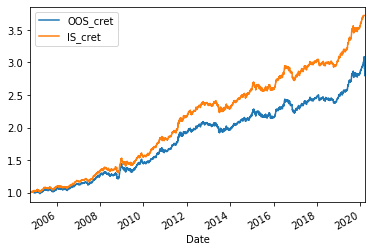

In [55]:
cdf = FPS.CompareSamples()
cdf[["OOS_cret", "IS_cret"]].loc["2004":].plot()

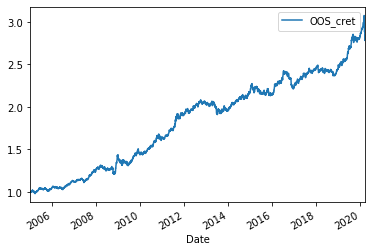

In [56]:
cdf = FPS.CompareSamples()
qdf = cdf[["OOS_cret"]].loc["2005-01":]
qdf = qdf/qdf.iloc[0]
qdf.plot()

In [57]:
qdf.tail()

,OOS_cret
Date,
2020-03-16,2.892134
2020-03-17,2.865873
2020-03-18,2.781789
2020-03-19,2.788344
2020-03-20,2.841159


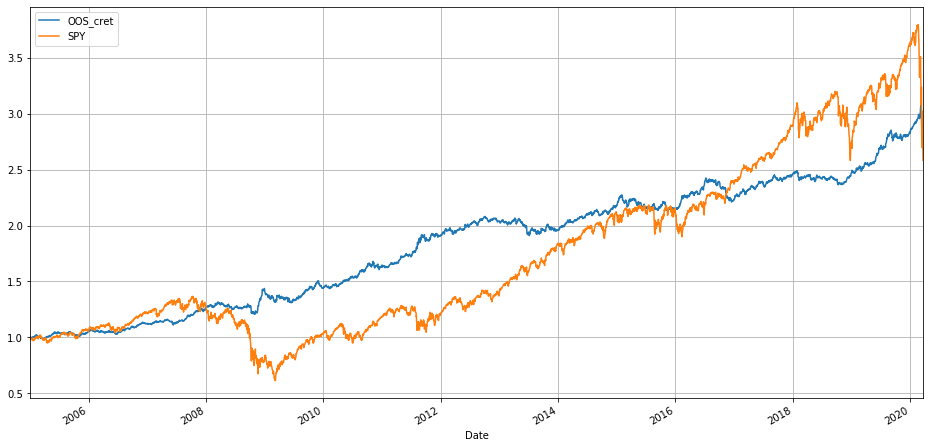

In [58]:
zdf = pd.concat([qdf, z], axis = 1).dropna()
(zdf/zdf.iloc[0]).plot(figsize=(16,8), grid=True)

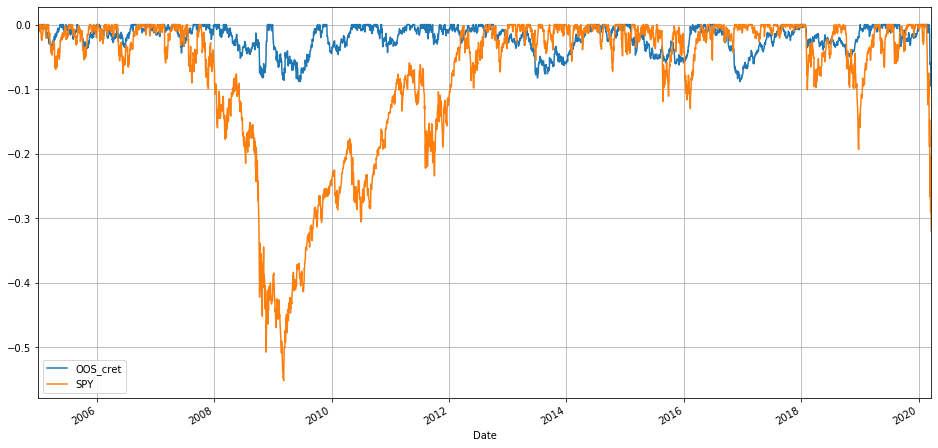

In [59]:
drawdowns = get_drawdowns(zdf)
drawdowns.plot(figsize=(16,8), grid=True)

In [60]:
zdf = zdf/zdf.iloc[0]
total_days = (zdf.index.max() - zdf.index.min()).days
broker_loss = total_days/30*0.001
p = zdf.tail(1)[["OOS_cret"]]/(1+broker_loss)
cret = p**(365/total_days) - 1
maxdd = drawdowns["OOS_cret"].min(), drawdowns["OOS_cret"].quantile(0.01)
maxdd2 = drawdowns["OOS_cret"].tail(200).min(), drawdowns["OOS_cret"].tail(200).quantile(0.01)
print(cret.values[0], maxdd, maxdd2)
p = zdf.tail(1)[["SPY"]]/(1+broker_loss)
cret = p**(365/total_days) - 1
maxdd = drawdowns["SPY"].min(), drawdowns["SPY"].quantile(0.01)
maxdd2 = drawdowns["SPY"].tail(200).min(), drawdowns["SPY"].tail(200).quantile(0.01)
print(cret.values[0], maxdd, maxdd2)


[0.0591314] (-0.09544450827517037, -0.0796750179354487) (-0.09544450827517037, -0.07631090469494192)
[0.05255833] (-0.5518943153128106, -0.45542071422588004) (-0.31978064971655806, -0.2906587866347876)


In [61]:
broker_loss

0.18516666666666667

In [62]:
# total_days = (zdf.index.max() - zdf.index.min()).days
# broker_loss = total_days/30*0.001
# p = zdf.tail(1)[["OOS_cret"]]/(1+broker_loss)
# cret = p**(365/total_days) - 1
# maxdd = drawdowns["OOS_cret"].min(), drawdowns["OOS_cret"].quantile(0.01)
# maxdd2 = drawdowns["OOS_cret"].tail(200).min(), drawdowns["OOS_cret"].tail(200).quantile(0.01)
# print(cret.values[0], maxdd, maxdd2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff38de83d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff38df2ed68>)

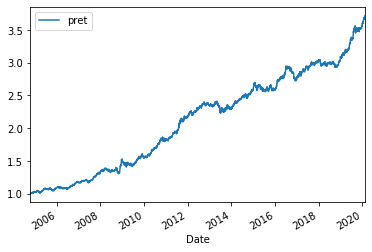

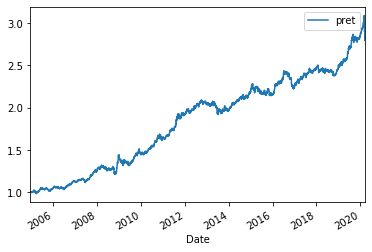

In [63]:
np.cumprod(1+FPS.rs_is.df).plot(), np.cumprod(1+FPS.rs_oos.df).plot()

In [2]:
sharpe = cxtpy.metrics_functions.sharpe
vol = cxtpy.metrics_functions.volatility
maxdd = cxtpy.metrics_functions.max_drawdown_2

In [3]:
%%time
d0 = datetime.datetime(2014,1,1)
d1 = datetime.datetime(2018,1,1)
m = MongoStorage(None)
x = m.client["AnalysisEvo"]["Strategy"].distinct("Name")
x.sort()
filter_name = x[20:1000]
filter_meta = m.FilterAndGetMetadata({"Name": {"$in": filter_name}, "StartDate": {"$lte": d0}, "EndDate": {"$gte": d1}})

# id_list = [j["_id"] for j in filter_meta][0:500]
meta_df = pd.DataFrame(filter_meta).sort_values("EndDate").groupby("Name").last()
id_list = meta_df._id.values
strategy_list = meta_df.index.values

S = m.LoadAllSeriesFromId(id_list)

MongoStorage: Using local
CPU times: user 2.16 s, sys: 216 ms, total: 2.38 s
Wall time: 3.02 s


In [4]:
df_list = [s.df for s in S]
len(df_list),len(strategy_list)

(438, 438)

In [5]:
data_df = pd.DataFrame(dict(df = df_list, names = strategy_list))

In [6]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
cluster_df = knn_cluster(data_df, a1, a2)
# cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "risk parity")
wdf["weight"].describe()
# wdf

CPU times: user 5.53 s, sys: 39 ms, total: 5.57 s
Wall time: 4.17 s


count    438.000000
mean       0.002283
std        0.008192
min        0.000000
25%        0.000302
50%        0.000540
75%        0.001406
max        0.093908
Name: weight, dtype: float64

In [7]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
cluster_df = knn_cluster(data_df, a1, a2)
# cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "eq")
# wdf
wdf["weight"].describe()

CPU times: user 4.49 s, sys: 11.5 ms, total: 4.51 s
Wall time: 4.08 s


count    438.000000
mean       0.002283
std        0.003206
min        0.000962
25%        0.001010
50%        0.001163
75%        0.002128
max        0.025000
Name: weight, dtype: float64

In [8]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
# cluster_df = knn_cluster(data_df, a1, a2)
cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "risk parity")
wdf["weight"].describe()

CPU times: user 1.17 s, sys: 3.77 ms, total: 1.18 s
Wall time: 197 ms


count    438.000000
mean       0.002283
std        0.011559
min        0.000000
25%        0.000505
50%        0.000814
75%        0.001232
max        0.122771
Name: weight, dtype: float64

In [9]:
%%time
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, 
              "allocate_method": "TwoLayer_KNN_RP", "n_cluster": 3, 
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }
FPS = FullPortfolioSimulation(sim_name = "KNNRP01", save = False)
FPS.MultiSimulation(total_simulation = 16, **sim_kwargs)

ST = StatisticalTest(FPS, FPS)
ST.self_table(FPS)

MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage

,mean,std,min,25%,50%,75%,max
Metric,,,,,,,
CAGR,0.019779,0.037811,-0.023545,-0.007171,0.010294,0.037652,0.117089
Volatility,0.086640,0.010835,0.061101,0.080998,0.091178,0.092976,0.098508
Sharpe,0.221048,0.412444,-0.280541,-0.083441,0.111263,0.446210,1.188627
Calmar,0.345581,0.617543,-0.267662,-0.054894,0.106650,0.478634,1.990793
Sortino,0.278800,0.518539,-0.303404,-0.091352,0.128493,0.492519,1.589911
Positive Periods,0.536356,0.015652,0.497159,0.531786,0.537373,0.543618,0.561983
Average Positive,0.003408,0.000449,0.002687,0.003064,0.003547,0.003814,0.003873
Average Negative,-0.003740,0.000488,-0.004518,-0.004011,-0.003898,-0.003387,-0.002934
ETL,-0.014272,0.001758,-0.017303,-0.015086,-0.014630,-0.014050,-0.009442


In [10]:
%%time
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, "allocate_method": "CRP",
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }
FPS2 = FullPortfolioSimulation(sim_name = "CRP01", save = False)
FPS2.MultiSimulation(total_simulation = 16, **sim_kwargs)

ST2 = StatisticalTest(FPS, FPS2)
ST2.self_table(FPS2)


MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage: Using local
MongoStorage

,mean,std,min,25%,50%,75%,max
Metric,,,,,,,
CAGR,0.022771,0.015946,-0.010466,0.013362,0.026062,0.035719,0.045607
Volatility,0.038656,0.005771,0.031107,0.034566,0.037262,0.041141,0.051672
Sharpe,0.600996,0.403154,-0.211499,0.342004,0.746474,0.893617,1.118153
Calmar,0.684950,0.522377,-0.237731,0.348982,0.761521,0.971896,1.837585
Sortino,0.711459,0.481021,-0.215707,0.384962,0.918686,1.072466,1.360005
Positive Periods,0.540598,0.021634,0.513736,0.523741,0.537806,0.547425,0.580282
Average Positive,0.001567,0.000190,0.001372,0.001415,0.001510,0.001686,0.001956
Average Negative,-0.001634,0.000223,-0.002109,-0.001756,-0.001539,-0.001478,-0.001357
ETL,-0.006305,0.001194,-0.008977,-0.006888,-0.006046,-0.005552,-0.004964


In [11]:
ST.self_table(FPS)

,mean,std,min,25%,50%,75%,max
Metric,,,,,,,
CAGR,0.019779,0.037811,-0.023545,-0.007171,0.010294,0.037652,0.117089
Volatility,0.086640,0.010835,0.061101,0.080998,0.091178,0.092976,0.098508
Sharpe,0.221048,0.412444,-0.280541,-0.083441,0.111263,0.446210,1.188627
Calmar,0.345581,0.617543,-0.267662,-0.054894,0.106650,0.478634,1.990793
Sortino,0.278800,0.518539,-0.303404,-0.091352,0.128493,0.492519,1.589911
Positive Periods,0.536356,0.015652,0.497159,0.531786,0.537373,0.543618,0.561983
Average Positive,0.003408,0.000449,0.002687,0.003064,0.003547,0.003814,0.003873
Average Negative,-0.003740,0.000488,-0.004518,-0.004011,-0.003898,-0.003387,-0.002934
ETL,-0.014272,0.001758,-0.017303,-0.015086,-0.014630,-0.014050,-0.009442


In [12]:
ST.self_table(FPS2)

,mean,std,min,25%,50%,75%,max
Metric,,,,,,,
CAGR,0.022771,0.015946,-0.010466,0.013362,0.026062,0.035719,0.045607
Volatility,0.038656,0.005771,0.031107,0.034566,0.037262,0.041141,0.051672
Sharpe,0.600996,0.403154,-0.211499,0.342004,0.746474,0.893617,1.118153
Calmar,0.684950,0.522377,-0.237731,0.348982,0.761521,0.971896,1.837585
Sortino,0.711459,0.481021,-0.215707,0.384962,0.918686,1.072466,1.360005
Positive Periods,0.540598,0.021634,0.513736,0.523741,0.537806,0.547425,0.580282
Average Positive,0.001567,0.000190,0.001372,0.001415,0.001510,0.001686,0.001956
Average Negative,-0.001634,0.000223,-0.002109,-0.001756,-0.001539,-0.001478,-0.001357
ETL,-0.006305,0.001194,-0.008977,-0.006888,-0.006046,-0.005552,-0.004964


In [13]:
ST.pair_table(FPS, FPS2)

,mean,std,min,25%,50%,75%,max,greater_pct,t-statistic,sign,better
Metric,,,,,,,,,,,
CAGR,-0.002993,0.041005,-0.056087,-0.035937,-0.007903,0.014486,0.102294,0.4375,-0.291926,==,False
Volatility,0.047984,0.012291,0.020353,0.040946,0.048488,0.059071,0.062213,1.0000,15.615528,>>,False
Sharpe,-0.379949,0.565826,-1.186889,-0.799074,-0.410237,-0.079599,0.795251,0.1875,-2.685975,<<,False
Calmar,-0.339369,0.829999,-1.878223,-0.885750,-0.382855,0.033126,1.614930,0.3125,-1.635515,==,False
Sortino,-0.432659,0.696402,-1.432303,-0.896263,-0.519464,-0.122029,1.176264,0.1875,-2.485107,<<,False
Positive Periods,-0.004242,0.016749,-0.041436,-0.016634,0.002817,0.006303,0.016997,0.5625,-1.012993,==,False
Average Positive,0.001841,0.000531,0.000983,0.001428,0.001944,0.002291,0.002488,1.0000,13.853812,>>,True
Average Negative,-0.002105,0.000534,-0.003129,-0.002457,-0.002040,-0.001673,-0.001237,0.0000,-15.758147,<<,False
ETL,-0.007967,0.001876,-0.011534,-0.009152,-0.008055,-0.006934,-0.003757,0.0000,-16.986479,<<,False


In [14]:


fdf = reduce(lambda x, y: pd.merge(x, y, on = 'Date', how = "outer"), df_list)
fdf = fdf.sort_index().loc["2015":"2017"]
fdf = fdf.fillna(0)
print(fdf.index.min(), fdf.index.max())

2015-01-01 00:00:00 2017-12-30 00:00:00


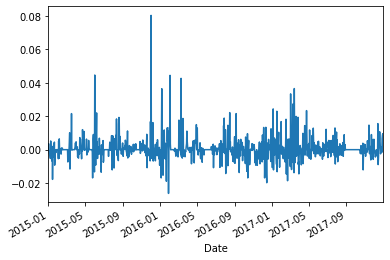

In [15]:
fdf.iloc[:,10].plot()

In [16]:
maxdd_df = fdf.resample("45d").apply(lambda x: maxdd(x))
mean_df = fdf.resample("45d").apply(lambda x: np.mean(x)).fillna(0)
std_df = fdf.resample("45d").apply(lambda x: np.std(x)).fillna(0)

ff = pd.concat([maxdd_df.T, mean_df.T, std_df.T], axis = 1)

In [59]:
names = ff.reset_index()["index"]
ff.head()

Date,2015-01-01 00:00:00,2015-02-15 00:00:00,2015-04-01 00:00:00,2015-05-16 00:00:00,2015-06-30 00:00:00,2015-08-14 00:00:00,2015-09-28 00:00:00,2015-11-12 00:00:00,2015-12-27 00:00:00,2016-02-10 00:00:00,...,2016-11-06 00:00:00,2016-12-21 00:00:00,2017-02-04 00:00:00,2017-03-21 00:00:00,2017-05-05 00:00:00,2017-06-19 00:00:00,2017-08-03 00:00:00,2017-09-17 00:00:00,2017-11-01 00:00:00,2017-12-16 00:00:00
_0087_TokyoDriftTF_SPY,-0.017741,-0.012580,-0.012722,-0.020844,-0.033711,-0.047992,-0.025400,-0.018910,-0.029775,-0.006210,...,0.003251,0.002361,0.002356,0.002132,0.003083,0.002387,0.003383,0.001701,0.001500,0.001819
_0170_2_VXXBCostaRica,-0.119657,0.000000,0.000000,0.000000,-0.053349,-0.040580,-0.036822,-0.019301,-0.012342,-0.006290,...,0.002903,0.000000,0.000000,0.001480,0.002571,0.000950,0.009451,0.000000,0.000000,0.000000
_0253_LargeMidAnomaly_SA,-0.016238,-0.008288,-0.002458,0.000000,0.000000,0.000000,-0.004116,-0.061652,-0.042493,-0.032260,...,0.003692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002673,0.001567
_0668_FuturesBreakoutTwo,-0.026015,-0.018655,-0.030688,-0.015312,-0.042987,-0.052034,-0.038791,-0.017333,-0.046468,-0.017922,...,0.003755,0.002459,0.002304,0.004243,0.003236,0.002532,0.002139,0.003119,0.002381,0.001458
_0922_DataMinedEMBM60_MMS,-0.021170,-0.021114,-0.032279,-0.034996,-0.014297,-0.025346,-0.018038,-0.025067,-0.012245,-0.019010,...,0.006129,0.002572,0.002775,0.002262,0.002022,0.003364,0.001981,0.002600,0.003630,0.002771


In [60]:
pca = PCA()
pca.fit(ff.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [61]:
features = pca.fit_transform(ff.values)
features_plot = features[:, 0:2]
features_kmean = features[:, 0:20]

In [62]:
pca.explained_variance_ratio_.cumsum()

array([0.46207892, 0.53084531, 0.5901177 , 0.63908634, 0.67415148,
       0.70508867, 0.73144629, 0.75746198, 0.78127028, 0.80372364,
       0.82440086, 0.84456977, 0.86344908, 0.88037959, 0.89522254,
       0.90860976, 0.92156656, 0.93387697, 0.94566724, 0.95739945,
       0.96733667, 0.97645554, 0.98422654, 0.99119244, 0.99715113,
       0.99760063, 0.997858  , 0.99806277, 0.99824153, 0.99841381,
       0.99855671, 0.99867885, 0.9987989 , 0.99891063, 0.99901178,
       0.99910395, 0.99918965, 0.99926969, 0.99934408, 0.99941177,
       0.99947575, 0.9995351 , 0.9995918 , 0.99964291, 0.99969014,
       0.99973523, 0.99977912, 0.99981566, 0.99984713, 0.99987563,
       0.99989443, 0.99990467, 0.99991383, 0.99992257, 0.99992983,
       0.99993673, 0.99994309, 0.99994884, 0.99995404, 0.99995838,
       0.99996263, 0.99996658, 0.99997046, 0.99997392, 0.99997726,
       0.99998038, 0.99998326, 0.999986  , 0.99998846, 0.99999086,
       0.99999316, 0.99999513, 0.99999698, 0.99999852, 1.     

In [63]:
nc = np.arange(2,30)
inertias = []
for n_cluster in nc:
    
    km = KMeans(n_clusters = n_cluster, random_state = 1)
    km.fit(features_kmean)
    inertias.append(km.inertia_)
    



In [64]:
in_df = pd.DataFrame(dict(nc = nc, ine = inertias))

best_cluster = in_df.iloc[in_df["ine"].idxmin(), 0]
print(best_cluster)
in_df.head(10)

29


,nc,ine
0,2,12.301431
1,3,10.977331
2,4,10.356149
3,5,9.859338
4,6,9.413614
5,7,9.159435
6,8,8.889640
7,9,8.638818
8,10,8.384772
9,11,8.163924


In [70]:
best_cluster = 10 #override
km = KMeans(n_clusters = best_cluster, random_state = 1)
km.fit(features_kmean)
cluster = km.predict(features_kmean)

In [71]:
ffdf = pd.DataFrame(dict(x = features[:, 0], y = features[:, 1], name = names))

In [72]:
ffdf["cluster"] = ["c_" + str(j) for j in cluster]

In [ ]:
ffdf.to_dict(orient = "records")

In [ ]:
for j in ffdf.cluster.unique():
    print(ffdf[ffdf.cluster==j])

In [74]:
ffdf.columns = ["x", "y", "name", "cluster"]
fig = px.scatter(ffdf, x = "x", y = "y", color = "cluster", hover_name = "name")
plot(fig)

'temp-plot.html'

In [ ]:
ffdf

In [116]:
df = S[0].df

# Run

In [ ]:
gsheet = "PortfolioSimulation"
wsheet = "TaskV2"
gt.do_task(gsheet = gsheet, wsheet = wsheet, TEST = True)

In [ ]:
time.sleep(10)
print("ok")

# Check Db Count

In [ ]:
for j in range(32):
    ss = "RAS_HRP_D{}_V2a".format(str(j).zfill(2))
    k = gt.CheckDbCount(ss)
    print(ss,k)

# Delete Simulations

In [ ]:
# sim_name = "RAS_CRP_D03_V2a"  
# gt.DeleteSimulations(sim_name)

In [ ]:
# for j in range(32):
#     ss = "RAS_CHRP_D{}_V2a".format(str(j).zfill(2))
#     k = gt.CheckDbCount(ss)
#     if k < 200:
#         sim_name = ss
#         gt.DeleteSimulations(ss)
    